CAISO DEMAND FORECASTING - CASE 

In this case, We'll use the forecaster class for forecasting Caiso load, Caiso is the Independent system operator (ISO) that serves California. Caiso load is one of the most challenging load to forecast due to its high volatility and the high penetration of renewable energy sources. More information at: https://www.caiso.com/Pages/default.aspx

Import Libraries

In [1]:
import sys
sys.path.append('src/')
from forecaster import Forecaster
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_eng import add_heating_cooling_degrees, create_dummy_variables, add_weekday_hour, add_month
pd.options.mode.chained_assignment = None

Understanding the data

In [2]:
#reading the caiso dataset
caiso_dataset = pd.read_csv('data/caiso_system_load.csv')
#reformatting the date time
caiso_dataset['interval_start_time'] = pd.to_datetime(caiso_dataset['interval_start_time'], utc = True,format ="%Y-%m-%d %H:%M:%S%z" )
caiso_dataset['interval_start_time'] = caiso_dataset['interval_start_time'].dt.tz_convert('US/Pacific')
#setting the index
caiso_dataset.set_index('interval_start_time', inplace=True)
caiso_dataset.index = caiso_dataset.index.strftime("%Y-%m-%d %H:%M")
caiso_dataset.index = pd.to_datetime(caiso_dataset.index, format="%Y-%m-%d %H:%M")
#printing some information about the dataset
caiso_dataset.describe()

,CAISO_system_load,temp_forecast_dayahead_bakersfield,temp_forecast_dayahead_los_angeles,temp_forecast_dayahead_san_francisco,dewpoint_forecast_dayahead_bakersfield,dewpoint_forecast_dayahead_los_angeles,dewpoint_forecast_dayahead_san_francisco
count,31367.000000,31356.000000,31356.000000,31356.000000,31379.000000,31379.000000,31379.000000
mean,25101.822202,67.162256,62.051442,56.583971,42.410284,51.043988,47.563275
std,4802.566584,16.539502,6.301371,6.267184,7.307178,10.052201,5.755707
min,14853.000000,34.000000,44.000000,40.000000,4.000000,-3.000000,22.000000
25%,21771.500000,53.300000,57.300000,52.000000,37.300000,46.000000,43.700000
50%,24100.000000,65.000000,62.000000,56.000000,42.700000,53.000000,48.000000
75%,26940.000000,80.000000,66.300000,60.700000,48.000000,59.000000,52.000000
max,51292.000000,115.000000,89.000000,85.000000,66.000000,71.000000,66.000000


Plotting the features and load

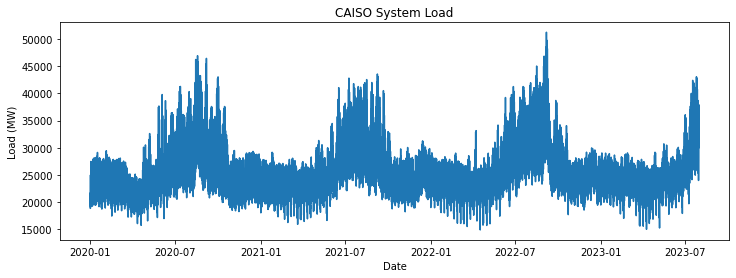

In [3]:
#plotting the target variable
plt.figure(figsize=(12,4))
plt.plot(caiso_dataset['CAISO_system_load'])
plt.title('CAISO System Load')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.show()

In the plot above, we can there is a strong monthly patter across the time for Caiso load, and the anual growth of load has been minimum during three years. 

Let's check the correlation between the variables

<AxesSubplot:>

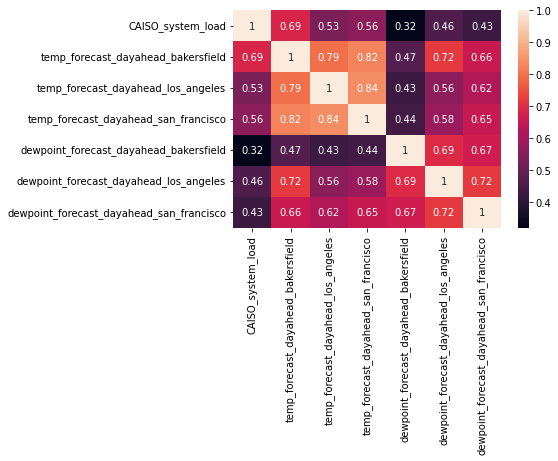

In [4]:
correlation = caiso_dataset.corr()
sns.heatmap(correlation, annot=True)

Some insights:
- Temperature forecast dayahead bakersfield: seems to be the most correlated variable with the load. 
- Temperatures are more correlated with load (0.69-0.56) than dew point temperatures (0.43-0.32).
- Temperatures have a very high correlation among them. This is due to the fact that they are all temperatures from different locations in California.

Lets get the data for modeling

In [5]:
caiso_data = caiso_dataset.loc[caiso_dataset.index < '2023-07-31 00:00:00']

Creating a forecaster object for the CAISO case, ingesting the data, and preprocessing the data

In [6]:
caiso_case = Forecaster(name = 'caiso_forecaster')
caiso_case.ingest(caiso_data,  y_column='CAISO_system_load' )
caiso_case.data_set = caiso_case.preprocess(caiso_case.data_set)

Our first try, it's the simplest one, a linear model

rmse is:  3734.21


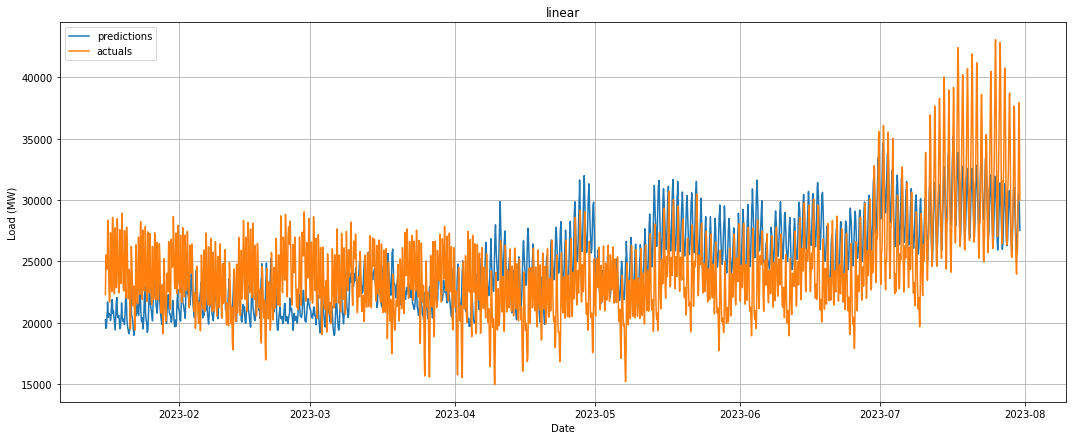

In [7]:
model_applied = 'linear'
caiso_case.train(model = model_applied)
rsme, preds = caiso_case.backtest()
print('rmse is: ', rsme)
caiso_case.plot_predictions(backtest = True)

rmse is 16% of the mean of the load (25,102 MW). Let's try a more complex model.

Training a xgboost regressor, and performing backtest we obtain

The rmse is:  2743.95


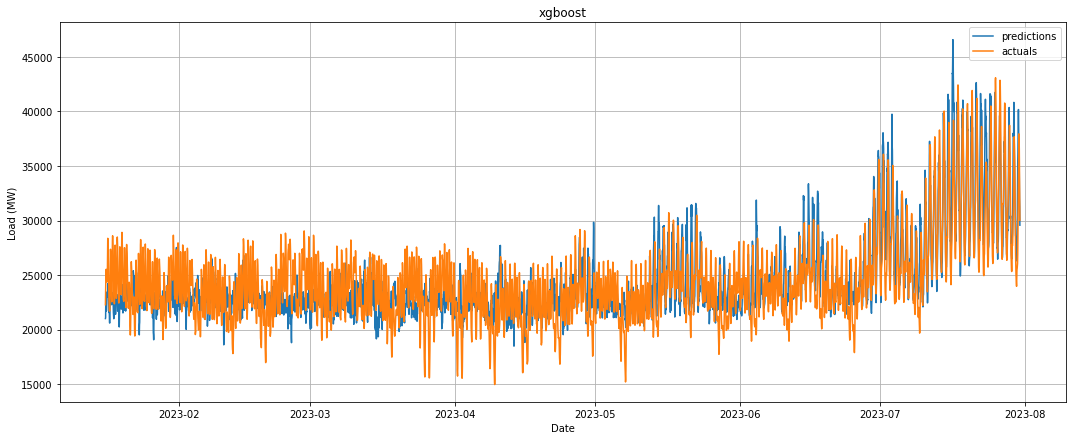

In [8]:
model_applied = 'xgboost'
caiso_case.train(model = model_applied)
rsme, preds = caiso_case.backtest()
print('The rmse is: ', rsme)
caiso_case.plot_predictions(backtest = True)

In this case, the rmse is 10.9% of the mean of the load

We also can determine the best model, by executing the model 'best_model' method.

In [9]:
best_model, rmse = caiso_case.best_model()

linear: 3734.21
ridge: 3734.21
lasso: 3485.06
xgboost: 2743.95
random_forest: 2674.25


The best model is the random forest model, with a rmse of 10.7% of the mean of the load

From my experience modeling load, there is a more direct relationship between cooling and heating degrees to load, compared with temperature vs load. 

Let's transform temperatures to heat and cooling degree, and drop temperature columns.

In this case, even when the formal definition of cooling and heating degree uses a base temperature of 65 F, the value of this referencete temperature can be fine tuned, improving the model performance.

In [10]:
temperature_cols = ['temp_forecast_dayahead_bakersfield', 'temp_forecast_dayahead_los_angeles', 'temp_forecast_dayahead_san_francisco']
# add heating and cooling degrees
caiso_data = add_heating_cooling_degrees(caiso_data, temperature_cols, temperature_reference = 65)
# ingest the modified dataset
caiso_case.ingest(caiso_data,  y_column='CAISO_system_load' )
#iterating through the models for calculated one with the lowest rmse
best_model, rmse = caiso_case.best_model()

linear: 2854.19
ridge: 2854.19
lasso: 2923.44
xgboost: 2740.18
random_forest: 2676.84


As heating and cooling degrees has a linear relationship with load, then all the linear models improved, and the tree based models keep almost the same performance.

Load is a variable driven by temperatures, and also daily life routines. it means hours, and dayweek features can be used to modeling these routines.
As the relationship between load hour, weekday and month is not linear or even proportional, we'll use a one hot encoders to transform the hour, weekday and month variables.

In [11]:
#adding weekday-hour feature
caiso_data = add_weekday_hour(caiso_data)
#adding dummy variables for weekday-hour
caiso_data = create_dummy_variables(caiso_data , 'weekday-hour')
#adding month as a variable
caiso_data = add_month(caiso_data)
#adding dummy variables for month
caiso_data = create_dummy_variables(caiso_data, 'month')
#ingesting the modified dataset
caiso_case.ingest(caiso_data,  y_column='CAISO_system_load' )

Running the best_model method, we obtain:

In [12]:
best_model, rmse = caiso_case.best_model()

linear: 1901.45
ridge: 1897.73
lasso: 2823.34
xgboost: 1651.89
random_forest: 1885.66


After adding the weekday-hour and month dummy variables, all the models have a lower rmse. The best model is the random forest regressor, with a rmse  of 6.5% of the mean load.

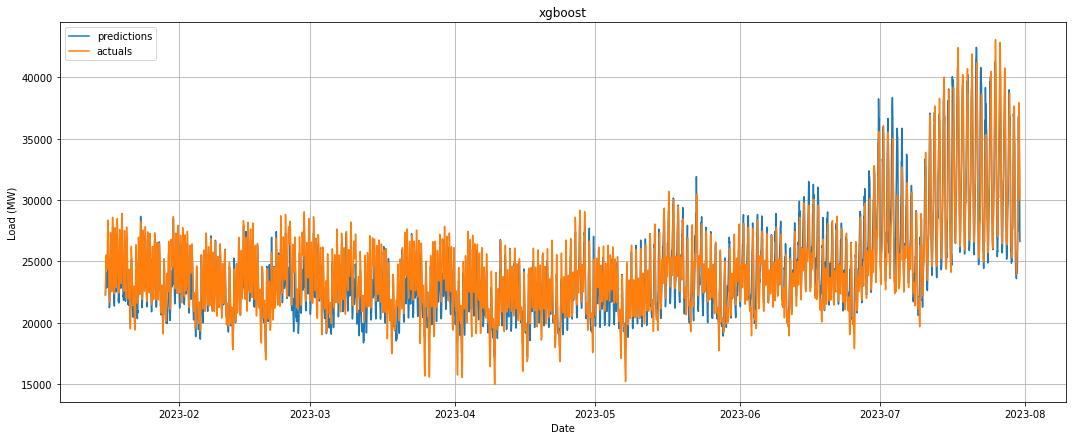

In [13]:
caiso_case.train(model = 'xgboost')
rsme, preds = caiso_case.backtest()
caiso_case.plot_predictions(backtest = True)

At the backtest plot on the test set, The model is able to capture the daily, weekly and even monthly patterns of the load.

Let's add the features to the original dataset for having those in the 24 final hours of the dataset.

In [14]:
#reading the caiso dataset
caiso_dataset = pd.read_csv('data/caiso_system_load.csv')
#reformatting the date time
caiso_dataset['interval_start_time'] = pd.to_datetime(caiso_dataset['interval_start_time'], utc = True,format ="%Y-%m-%d %H:%M:%S%z" )
caiso_dataset['interval_start_time'] = caiso_dataset['interval_start_time'].dt.tz_convert('US/Pacific')
caiso_dataset.set_index('interval_start_time', inplace=True)
caiso_dataset.index = caiso_dataset.index.strftime("%Y-%m-%d %H:%M")
caiso_dataset.index = pd.to_datetime(caiso_dataset.index, format="%Y-%m-%d %H:%M")
#adding heating and cooling degrees
caiso_dataset = add_heating_cooling_degrees(caiso_dataset, temperature_cols, temperature_reference = 65)
#adding weekday-hour feature
caiso_dataset = add_weekday_hour(caiso_dataset)
#adding dummy variables for weekday-hour
caiso_dataset = create_dummy_variables(caiso_dataset , 'weekday-hour')
#adding month as a variable
caiso_dataset = add_month(caiso_dataset)
#adding dummy variables for month
caiso_dataset = create_dummy_variables(caiso_dataset , 'month')
caiso_dataset = caiso_dataset.drop(columns=['CAISO_system_load'])
#getting the data to predict
data_to_predict = caiso_dataset.loc[caiso_dataset.index >= '2023-07-31 00:00:00']

Making predictions for the last 24 hours of the data (from 07-30-2023), with the best model we expect a rmse around 6.5% compared from the mean of load.

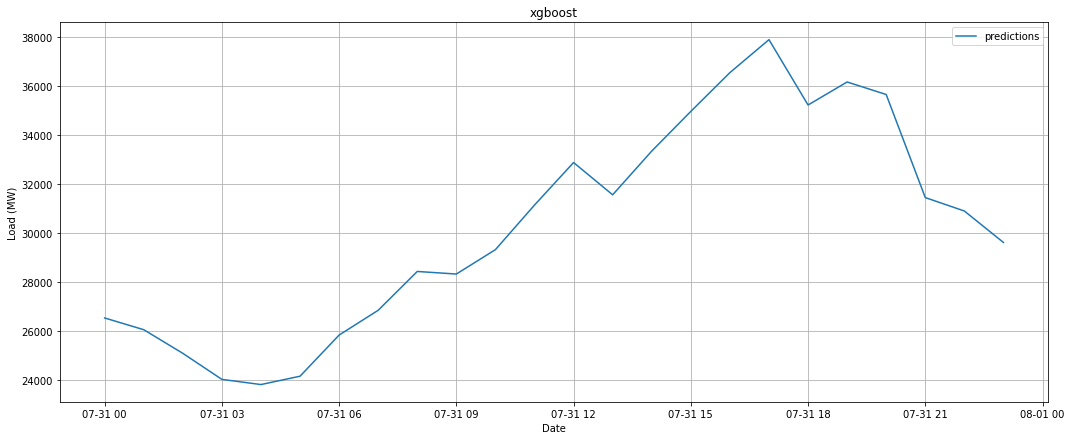

In [15]:
preds = caiso_case.forecast(data_to_predict)
caiso_case.plot_predictions(backtest = False)

Looking at the shape of the curve for the last 24 hours, it has the lowest point between 3 a.m and 5 a.m and its peak around 5 pm, after that the curve declines. 

Future Work:
- Add more features to the model, like holidays, and year.
- Correct the distribution of features, some not normally distributed.
- Feature selection.
- Hyperparameter tuning for the models.
- Add transformer, lstm models.